# Localization with a known map &mdash; Part 2 <br/> Basic Inference with Particle Filters
<!-- "Inference with Particle Filters: Defining the Localization Model and Basic Inference Techniques" -->


In the second part of this tutorial, our primary focus will be on defining the localization model and performing inference using Gen's particle filter package.
We will use the components established in Part 1, and will employ Gen's static modeling language, which enables us to construct an efficient model for localization.
Subsequently, we will apply particle filters to perform inference in our localization model (...also utilizing Gen's generative function combinators... Unfold to unfold the slam markov chain). Particle filters offer a standard approach for estimating therobot's position based on the known map and sensor observations.

Firstly, we will run a standard particle filter using a default proposal. This approach will allow us to obtain a decent estimate of the robot's position. In order to improve the accuracy of our inference, we will introduce a series of Metropolis-Hastings (MH) "drift" moves.

In the 3rd part of this tutorial, we will go beyond the standard approach and introduce improvements &mdash; namely "grid proposals" &mdash; to enhance the precision of our inference process, enabling more robust localization results.

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [9]:
include("src/localization_part_1.jl")

Loading data from `../data/task_inputs/example_1.json`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64
Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, Some(100.0)], var"##sensor_model_GPU#455", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [3]:
#nbx --fname="src/localization_part_2.jl"
using GenParticleFilters

## Noisy controls

Create noisy controls, run the cell below till you are happy with the amount of noise.

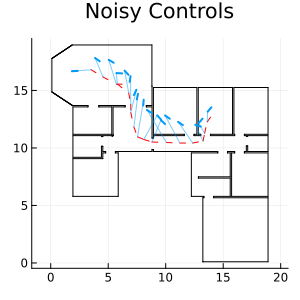

In [6]:
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(300,300), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!([_ps[1]], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],ps)
    plot!([q], c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
myplot

## Static Localization Model

(PLACEHOLDER) Graphical model of probabilistic SLAM:

```julia
     1        2        3                t        "model time"
     0        1        2                t-1      "chain time" (this will make sense in Part 2)

             u[1]     u[2]      ...    u[t-1]    "observed"
              |        |                 |        
    p[1] --- p[2] --- p[3] ---  ... --- p[t] 
     |        |        |                 |
    y[1]     y[2]     y[3]      ...     y[t]     "observed"
     |        |        |                 |
     m        m        m                 m       "observed" (in contrast to SLAM)
```

In [7]:
#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol)
    
    p,_ = state
    u = us[t]

    p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
    x  = {:sensor} ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol)
    
    state = (p, x)
return state
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [11]:
#nbx
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, x), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [12]:
#nbx
add_addr_prefix(t_chain, addr) = t_chain==0 ? addr : :chain => t_chain => addr

add_addr_prefix (generic function with 1 method)

In [13]:
#nbx
function constraints(t_chain::Int, _zs, _as)
    ch = choicemap()
    x  = polar_inv(_zs[t_chain+1],_as)
    ch[add_addr_prefix(t_chain, :sensor => :x)] = x
    return ch
end

constraints (generic function with 1 method)

In [14]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)
get_obs(tr,t)      = tr[][t][2]
get_first_obs(tr)  = get_obs(tr,1)

get_first_obs (generic function with 1 method)

In [27]:
#nbx
function plot_slam_trace!(tr; show_obs=true)
    T,m, = get_args(tr)
    ps = get_pose.([tr],1:T+1)
    xs = get_obs.([tr],1:T+1)

    myplot = plot(size=(300,300), 
        aspect_ratio=1., legend=nothing)
        
    plot!(_ps, c=:red)
    plot!(ps, c=col[1])
    plot!(_segs,  c=:black)
    plot!(_boxes, c=:magenta)
    if show_obs
        for (x,p) in zip(xs, ps)
            myplot = scatter!(x .* p, c=col[1], markerstrokewidth=0, markersize=1)
        end
    end
    return myplot
end

plot_slam_trace! (generic function with 1 method)

### Example trace

In [16]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0        = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.25
hd_noise = 10/360*2π

filter_size = 10
s_noise     = 0.1
outlier     = 0.0
outlier_vol = 1.0

args = (
    the_map,                           # Map
    us_noisy,                          # Controls
    p0, x0_noise, hd0_noise,           # Pose prior model
    x_noise, hd_noise,                 # Motion model
    filter_size, s_noise, outlier, outlier_vol   # Sensor model
);

T = 2
tr = simulate(static_slam_model, (T, args...))
get_choices(tr)

│
├── :pose
│   │
│   ├── :hd : 0.0730884701609937
│   │
│   └── :x : [1.334605037104656, 16.784561385933404]
│
├── :sensor
│   │
│   └── :x : [[Inf, Inf], [Inf, Inf], [-1.2814447916210987, -0.3056488753227715], [-1.3226084561436136, -0.2514350726259168], [-1.232156814783843, -0.1834707955253923], [-1.3032771253242206, -0.19161254081401416], [-1.3021029855546544, -0.20322407591845673], [-1.4497826453119798, -0.24754113320274407], [-1.2408047703615412, -0.06045569772842408], [-1.2131623086188585, 0.08635639284485927], [-1.3398235182968725, -0.4511970541522231], [-1.29755040968193, -0.29880220723842166], [-1.2433139180438397, -0.10876951467897006], [-1.3658878699214296, -0.2976991441340875], [-1.2192404402828187, -0.15980904661493645], [-1.1279049805484203, -0.36623728520676846], [-1.2352342091484754, -0.41336281238775724], [-1.3160610520110103, -0.5717316002646109], [-1.3991287044024503, -0.4941280937116491], [-1.2274065734532051, -0.6109910657154081], [-1.300348865103393, -0.6989143520

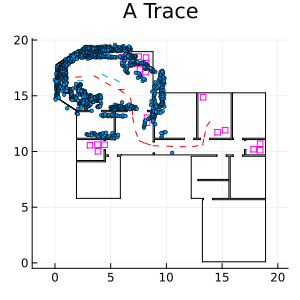

In [17]:
ch   = merge([constraints(t,_zs,_as) for t=0:T]...);
tr,w = generate(static_slam_model, (T, args...), ch)
plot_slam_trace!(tr)

In [18]:
#nbx
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
argdiffs([0,0.0,1.0, 1])

(NoChange(), NoChange(), UnknownChange(), UnknownChange())

## Inference

### Particle Filter with default proposal

In [30]:
N = 1_000 # 1_000 works decent

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind    = 10
s_noise = 0.1
outlier = 1e-2
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
state = pf_initialize(static_slam_model, (0, args...), ch, N);



diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles
        pf_resample!(state, :multinomial)
    end

    ch = constraints(t,_zs,_as);    
    sec = @elapsed pf_update!(state, (t, args...), diffs, ch)
    
    ms = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

true, 1 (1222.49 ms)
true, 1 (1477.48 ms)
true, 2 (1208.58 ms)
true, 2 (1515.00 ms)
true, 1 (1554.22 ms)
true, 2 (1203.22 ms)
true, 1 (1525.04 ms)
true, 1 (1253.16 ms)
true, 1 (1434.26 ms)
true, 1 (1533.87 ms)
true, 1 (1266.07 ms)
true, 1 (1551.72 ms)
true, 1 (1276.55 ms)
true, 1 (1533.47 ms)
true, 1 (1537.99 ms)
true, 1 (1222.03 ms)
true, 1 (1501.54 ms)


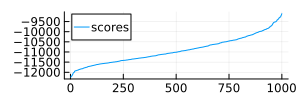

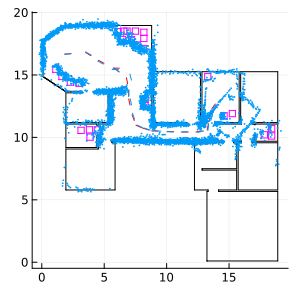

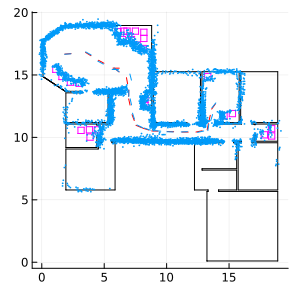

In [31]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))

display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end]))

Particle filter with default upddate and additional MH drift move

In [32]:
#nbx
@gen function pose_drift_proposal(tr, x_noise, hd_noise, vars=[:x,:hd])
    
    T, = get_args(tr)
    p  = get_pose(tr,T+1)

    if :x in vars 
        x  = {add_addr_prefix(T, :pose => :x)}  ~ diagnormal(p.x, [x_noise, x_noise])
    end

    if :hd in vars 
        hd = {add_addr_prefix(T, :pose => :hd)} ~ normal(p.hd, hd_noise)
    end
    
    tr
end;

In [38]:
# Number of particles 
# and drifts
N = 10
D = 100

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind = 10
s_noise = 0.1
outlier = 1e-1
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
state = pf_initialize(static_slam_model, (0, args...), ch, N);


diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    scores = get_score.(state.traces)
    sec = @elapsed pf_rejuvenate!(state, mh, (pose_drift_proposal, (0.1, 2/180*π, [:x, :hd])), D)
    diff_scores = get_score.(state.traces) - scores
    println(minimum(diff_scores), " " , maximum(diff_scores))

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles, or 
        # multinomial resampling
        pf_resample!(state, :multinomial)
    end

    ch   = constraints(t,_zs,_as);    
    sec += @elapsed pf_update!(state, (t, args...), diffs, ch)    
    ms   = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

200.23707065200676 1635.5584680455347
true, 1 (1217.36 ms)
761.8058108516839 1733.0717496237992
true, 1 (1446.36 ms)
90.37548778530254 1355.7401148304841
true, 1 (1548.31 ms)
220.38881178870724 1711.4596577787515
true, 1 (1511.88 ms)
113.34146314546206 1551.244162848198
true, 1 (1256.68 ms)
102.29726545381982 1786.6892572877196
true, 1 (1515.31 ms)
499.11062894804854 1499.0315663062593
true, 1 (1517.32 ms)
835.6441549991823 1955.7048280411682
true, 1 (1290.06 ms)
484.7382624220345 2035.6638352722503
true, 1 (1507.91 ms)
180.31107228899327 2266.324718558715
true, 1 (1561.84 ms)
497.8749004976062 2378.6950757829372
true, 1 (1297.76 ms)
335.8286103853525 2340.4535270952465
true, 1 (1569.75 ms)
42.25562560097933 2559.1394989835107
true, 1 (1587.81 ms)
191.04371529214313 2464.078261759756
true, 1 (1338.57 ms)
651.4797862701926 2434.9161094145156
true, 1 (1585.35 ms)
324.5679390905325 1884.7832367670344
true, 1 (1584.48 ms)
227.39679721348148 1262.5992267223128
true, 1 (1308.75 ms)


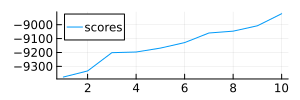

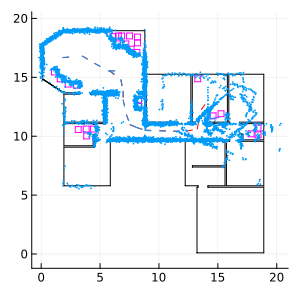

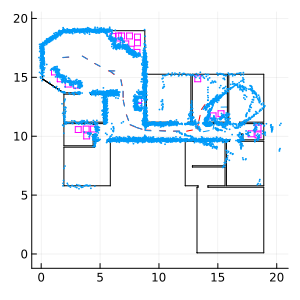

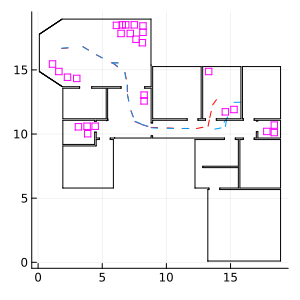

In [39]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))
display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end], show_obs=true))
display(plot_slam_trace!(trs[end], show_obs=false))